# $n$-step TD on a random walk

We consider a modified random Markov process (MRP) presented in example 6.2

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numba import njit

In [2]:
sns.set_palette("colorblind")

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
np.set_printoptions(linewidth=150)

The state-value update using TD-1 is
$$
V(S_t) \gets V(S_t) + \alpha\left[R_{t+1} + \gamma V(S_{t+1}) - V(S_t)\right].
$$

The state-value update using TD-2 is
$$
V(S_t) \gets V(S_t) + \alpha\left[ R_{t+1} + \gamma R_{t+2} + \gamma^2 V(S_{t+2}) - V(S_t) \right].
$$

For any $n>2$, the state-value update of TD-$n$ is
$$
V(S_t) \gets V(S_t) + \alpha\left[\sum_{k=1}^n \gamma^{k-1} R_{t+k} + \gamma^n V(S_{t+n}) - V(S_t) \right].
$$

In [15]:
n_states = 19 + 1 # total state plus terminal state
states = np.arange(n_states)
mrp = np.zeros((n_states, n_states))
mrp[0, 0] = 1.0

for i in range(1, n_states):
    iprev = i - 1
    inext = (i + 1) % n_states
    mrp[i, [i - 1, inext]] = 1/2

mrp

array([[1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0

In [16]:
n = n_states -1
reward_matrix = np.eye(n)
reward_matrix = reward_matrix - np.eye(n, k=1) / 2 - np.eye(n, k=-1) / 2
y = np.zeros(n)
y[-1] = 1/2
y[0] = -1/2

value_array = np.linalg.solve(reward_matrix, y)

In [17]:
@njit
def set_seed(seed):
    np.random.seed(seed)


@njit
def sample_run(s):
    s_hist = [s]
    r_hist = []
    r = 0
    while s != 0:
        snext = np.random.multinomial(1, mrp[s]).argmax()
        r = 1 if (s == n_states - 1) and (snext == 0) else 0
        s = snext
        s_hist.append(s)
        r_hist.append(r)
    
    s_hist = np.array(s_hist[:-1])
    r_hist = np.array(r_hist)
    return s_hist, r_hist

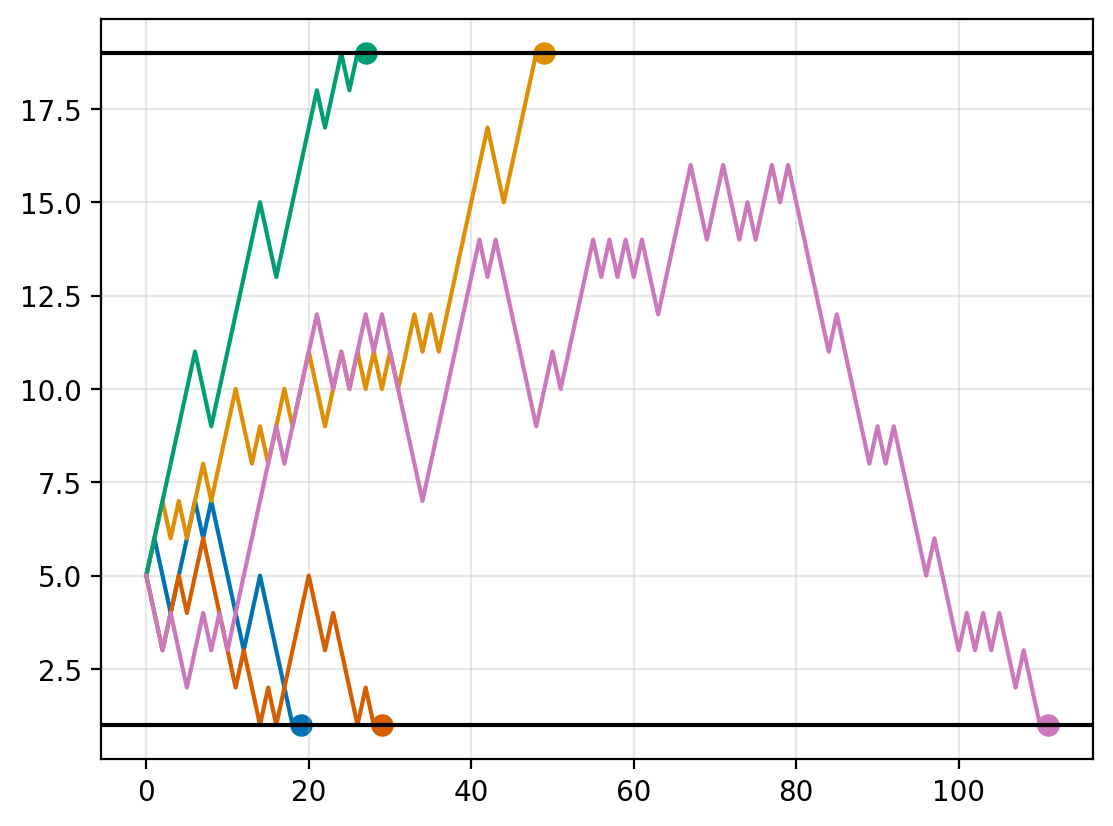

In [18]:
set_seed(2718)

n_sims = 5

for n in range(n_sims):
    s_hist, r_hist = sample_run(5)
    len_hist = len(s_hist)
    plt.plot(s_hist)
    plt.scatter(len_hist, s_hist[-1], s=50)

plt.grid(alpha=0.3)
plt.axhline(y=n_states - 1, c="black")
plt.axhline(y=1, c="black")

In [40]:
@njit
def compute_return(sprev, snext):
    if (sprev == n_states - 1) and (snext == 0):
        r = 1
    elif (sprev == 1) and (snext == 0):
        r = -1
    else:
        r = 0

    return r

In [41]:
@njit
def run_and_update_tdn(value, s, alpha, gamma, td_size, steps):
    """
    Sample from the MRP and update the TD-n algorithm
    ----
    Parameters:
    value: np.array
        Current value estimate
    s: float
        initial state
    alpha: float
        learning rate
    gamma: float
        discount
    rewards_td: np.array
        FIFO buffer of rewards
    """
    value = value.copy()
    strack = ...
    rewards_td = np.zeros(td_size)
    discount_array = gamma ** np.arange(td_size)
    
    for t in range(steps):
        snext = np.random.multinomial(1, mrp[s])
        
        r = compute_reward(s, snext)
        rewards_td = np.roll(rewards_td, -1)
        rewards_td[-1] = r

        target = (discount_array * rewards_td).sum() + value[strack]
        value[s] = value[s] + alpha * (target - value[s])

    return value

In [28]:
td_size = 3
rewards = np.zeros(td_size)
rewards

array([0., 0., 0.])

In [34]:
rewards = np.arange(4)
rewards

array([0, 1, 2, 3])

In [35]:
np.roll(rewards, -1)

array([1, 2, 3, 0])

In [ ]:
r0 r1 r2
r1 r2 r3